In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain import hub
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [12]:
# --- Tool 1: Recent OpenAI Blog Posts ---
print("---LOADING TOOL 1 DOCS---")
urls1 = [
    "https://openai.com/index/o3-o4-mini-system-card-addendum-operator-o3/",
    "https://openai.com/index/emergent-misalignment/"
]
docs1 = [WebBaseLoader(url).load() for url in urls1]
docs_list1 = [item for sublist in docs1 for item in sublist]

# --- Tool 2: Niche RAG/Framework Blogs ---
print("---LOADING TOOL 2 DOCS---")
urls2 = [
    "https://langchain-ai.github.io/langgraph/concepts/why-langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/#2-create-a-stategraph"
]
docs2 = [WebBaseLoader(url).load() for url in urls2]
docs_list2 = [item for sublist in docs2 for item in sublist]

---LOADING TOOL 1 DOCS---
---LOADING TOOL 2 DOCS---


In [13]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splits1 = splitter.split_documents(docs_list1)
splits2 = splitter.split_documents(docs_list2)

In [8]:

embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

C:\Users\SAI SURYA TEJA\AppData\Local\Temp\ipykernel_13416\2731752069.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")
c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:

vectorstore1 = FAISS.from_documents(splits1, embedding_model)
retriever1 = vectorstore1.as_retriever()
retriever_tool_openai_blog = create_retriever_tool(
    retriever1,
    "retriever_openai_blog",
    "Search and run information from recent OpenAI blog posts"
)

In [21]:


vectorstore2 = FAISS.from_documents(splits2, embedding_model)
retriever2 = vectorstore2.as_retriever()
retriever_tool_rag = create_retriever_tool(
    retriever2,
    "retriever_rag_blogs",
    "Search and run information from recent RAG and LangGraph blogs"
)



In [26]:
tools = [retriever_tool_openai_blog, retriever_tool_rag]

In [22]:
retriever_tool_rag.invoke("stategraph")

'graph_builder = StateGraph(State)\n\nOur graph can now handle two key tasks:\n\nEach node can receive the current State as input and output an update to the state.\nUpdates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax.\n\n\n\nConcept\nWhen defining a graph, the first step is to define its State. The State includes the graph\'s schema and reducer functions that handle state updates. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values. To learn more about state, reducers, and related concepts, see LangGraph reference docs.\n\n2. Create a StateGraph¶\nNow you can create a basic chatbot using LangGraph. This chatbot will respond directly to user messages.\nStart by creating a StateGraph. A StateGraph object

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], lambda x, y: x + y]

def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="llama3-70b-8192").bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

def grade_documents(state) -> Literal["generate", "rewrite"]:
    print("---CHECK RELEVANCE---")
    class Grade(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
    model = ChatGroq(model="llama3-70b-8192").with_structured_output(Grade)
    prompt = PromptTemplate(
        template="Is this document relevant to the question? Document: {context} Question: {question} Reply 'yes' or 'no'.",
        input_variables=["context", "question"],
    )
    chain = prompt | model
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content
    score = chain.invoke({"question": question, "context": docs}).binary_score
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"

def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content
    prompt = hub.pull("rlm/rag-prompt")
    llm = ChatGroq(model="llama3-70b-8192")
    rag_chain = prompt | llm | StrOutputParser()
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

def rewrite(state):
    print("---REWRITE---")
    messages = state["messages"]
    question = messages[0].content
    msg = [HumanMessage(content=f"Improve this question: {question}")]
    model = ChatGroq(model="llama3-70b-8192")
    response = model.invoke(msg)
    return {"messages": [response]}

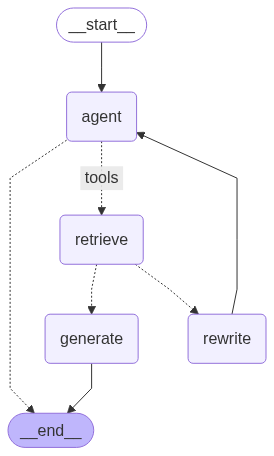

In [28]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition, {"tools": "retrieve", END: END})
workflow.add_conditional_edges("retrieve", grade_documents)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
graph = workflow.compile()

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
for query in [
    "Explain me the code for stategraph in LangGraph",
    "What is the purpose of LangGraph?",
]:
    print(f"\n---QUERY: {query}---")
    result = graph.invoke({"messages": [HumanMessage(content=query)]})
    print(f"RESPONSE: {result}\n")


---QUERY: Explain me the code for stategraph in LangGraph---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


C:\Users\SAI SURYA TEJA\AppData\Roaming\Python\Python312\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


RESPONSE: {'messages': [HumanMessage(content='Explain me the code for stategraph in LangGraph', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7q8kafch1', 'function': {'arguments': '{"query":"StateGraph LangGraph"}', 'name': 'retriever_rag_blogs'}, 'type': 'function'}, {'id': '1ffxnq1gs', 'function': {'arguments': '{"query":"StateGraph LangGraph"}', 'name': 'retriever_rag_blogs'}, 'type': 'function'}, {'id': '951n4q1qd', 'function': {'arguments': '{"query":"StateGraph LangGraph"}', 'name': 'retriever_rag_blogs'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 240, 'prompt_tokens': 1027, 'total_tokens': 1267, 'completion_time': 0.732459364, 'prompt_time': 0.04126957, 'queue_time': 0.0573808, 'total_time': 0.773728934}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--29f13bf6-ab9c-4114-807d-8a07e9553b47-0', tool_c